In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate

In [32]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)

    b1 = conv_block(p3, 512) #Bridge
    d2 = decoder_block(b1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [33]:
model = build_unet((128,128,3), 1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128, 128, 32) 128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 128, 128, 32) 0           batch_normalization_14[0][0]     
______________________________________________________________________________________________

In [34]:
import re
import os 
import glob 

class DataReader(object):
    def __init__(self, img_dir, label_dir, img_size):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
        self.num_imgs = len(self.imgs_path)
        self.width, self.height = img_size
    
    def __len__(self):
        return self.num_imgs
    
    
    def resize_crop_pad(self, img, is_label=False):
        """
        img -> PIL.Image
        return -> PIL.Image
        """
        target_width, target_height = self.width, self.height
        original_width, original_height = img.size
        original_aspect_ratio = original_width / original_height
        target_aspect_ratio = target_width / target_height
        if original_aspect_ratio > target_aspect_ratio:
            scale_factor = target_width / original_width
        else:
            scale_factor = target_height / original_height

        resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
        if is_label:
            padded_image = Image.new("L", (target_width, target_height))
        else:
            padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
        paste_x = (target_width - resized_image.width) // 2
        paste_y = (target_height - resized_image.height) // 2
        padded_image.paste(resized_image, (paste_x, paste_y))

        return padded_image
    
    def binarize_image(self, img):
        """
        image -> PIL.Image
        return -> PIL.Image
        """
        img = img.convert("L")
        img_array = np.array(img)
        binary_img_array = np.where(img_array > 0, 1, 0)
        binary_img = Image.fromarray(binary_img_array.astype(np.uint8), mode="L")
        return binary_img
    
    
    def find_label(self, img_path):
        label_path = re.sub(self.img_dir, self.label_dir, img_path)
        label_path = re.sub(".jpg", ".png", label_path)
        return label_path if os.path.exists(label_path) else None
    
    
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        label_path = self.find_label(img_path)
        img = Image.open(img_path)
        img = self.resize_crop_pad(img)
        label = Image.open(label_path)
        label = self.resize_crop_pad(label, is_label=True)
        label = self.binarize_image(label)
        img_np = np.array(img) / 255.
        label_np = np.expand_dims(np.array(label), -1)
        return img_np, label_np        
    
    def iter(self):
        for i in range(self.num_imgs):
            yield self[i]

In [35]:
batch_size = 4
img_dir = "/app/seg/data/images/train/"
label_dir = "/app/seg/data/labels/train/"
data_reader = DataReader(img_dir, label_dir, img_size=(128, 128))
dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [40]:
from tensorflow.keras.optimizers import Adam
from PIL import Image 
import numpy as np

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(dataset,
                    epochs=50)

Epoch 1/50
129/129 [==============================] - 3s 20ms/step - loss: 0.0936 - accuracy: 0.9613
Epoch 2/50
129/129 [==============================] - 2s 19ms/step - loss: 0.0895 - accuracy: 0.9630
Epoch 3/50
129/129 [==============================] - 3s 19ms/step - loss: 0.0842 - accuracy: 0.9653
Epoch 4/50
129/129 [==============================] - 2s 19ms/step - loss: 0.0777 - accuracy: 0.9677
Epoch 5/50
129/129 [==============================] - 3s 20ms/step - loss: 0.0784 - accuracy: 0.9675
Epoch 6/50
129/129 [==============================] - 2s 19ms/step - loss: 0.0754 - accuracy: 0.9687
Epoch 7/50
129/129 [==============================] - 3s 20ms/step - loss: 0.0719 - accuracy: 0.9702
Epoch 8/50
129/129 [==============================] - 2s 19ms/step - loss: 0.0699 - accuracy: 0.9710
Epoch 9/50
129/129 [==============================] - 3s 20ms/step - loss: 0.0666 - accuracy: 0.9722
Epoch 10/50
129/129 [==============================] - 2s 19ms/step - loss: 0.0612 - accura

In [195]:
def resize_crop_pad(img, is_label=False):
    """
    img -> PIL.Image
    return -> PIL.Image
    """
    target_width, target_height = 128, 128
    original_width, original_height = img.size
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height
    if original_aspect_ratio > target_aspect_ratio:
        scale_factor = target_width / original_width
    else:
        scale_factor = target_height / original_height

    resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
    if is_label:
        padded_image = Image.new("L", (target_width, target_height))
    else:
        padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
    paste_x = (target_width - resized_image.width) // 2
    paste_y = (target_height - resized_image.height) // 2
    padded_image.paste(resized_image, (paste_x, paste_y))

    return padded_image

In [41]:
img_dir = "/app/seg/data/images/test/"
label_dir = "/app/seg/data/labels/test/"
data_reader = DataReader(img_dir, label_dir, img_size=(128, 128))
test_dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
model.evaluate(test_dataset)

17/17 [==============================] - 0s 12ms/step - loss: 0.5783 - accuracy: 0.9010


[0.578319787979126, 0.9010323882102966]

(128, 128, 3)


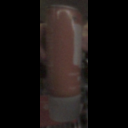

(128, 128, 1)


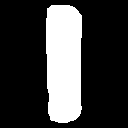

In [28]:
for x,y in test_dataset:
    img = x[0]
    print(img.shape)
    np_array = np.array(img) * 255
    img_p = Image.fromarray(np_array.astype(np.uint8))
    img_p.show()
    label = y[0]
    print(label.shape)
    label_array = np.squeeze(np.array(label)) * 255
    label_p = Image.fromarray(label_array.astype(np.uint8), "L")
    label_p.show()
    break

In [12]:
def resize_crop_pad(img, is_label=False):
    """
    img -> PIL.Image
    return -> PIL.Image
    """
    target_width, target_height = 128, 128
    original_width, original_height = img.size
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height
    if original_aspect_ratio > target_aspect_ratio:
        scale_factor = target_width / original_width
    else:
        scale_factor = target_height / original_height

    resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
    if is_label:
        padded_image = Image.new("L", (target_width, target_height))
    else:
        padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
    paste_x = (target_width - resized_image.width) // 2
    paste_y = (target_height - resized_image.height) // 2
    padded_image.paste(resized_image, (paste_x, paste_y))

    return padded_image

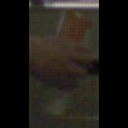

(128, 128)


In [59]:
test_img = "/app/seg/data/images/test/9300633320775_1708733394893_0_1708733407667_9604247.jpg"
test_img = Image.open(test_img)
test_img = resize_crop_pad(test_img)
test_img.show()
test_img_np = np.array(test_img) / 255.
test_img = np.expand_dims(test_img_np, 0)
result = model(test_img)
output = np.squeeze(result.numpy()) * 255
# output = np.expand_dims(output, -1)
print(output.shape)
output = Image.fromarray(output.astype(np.uint8), "L")


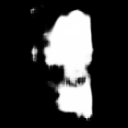

In [60]:
output

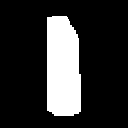

In [218]:
label

In [167]:
def apply_single_channel_mask(image, mask):
    mask_3_channels = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_image = np.where(mask_3_channels, image, 0)
    return masked_image

In [168]:
def crop_masked_region(masked_image, mask):
    # Find bounding box of the mask
    non_zero_indices = np.argwhere(mask)
    min_y, min_x = np.min(non_zero_indices, axis=0)
    max_y, max_x = np.max(non_zero_indices, axis=0)

    # Crop out the region containing the mask
    cropped_masked_image = masked_image[min_y:max_y+1, min_x:max_x+1]

    return cropped_masked_image

In [172]:
seg = apply_single_channel_mask(img, np.array(label))
cropped_masked_image = crop_masked_region(seg, label)
seg = Image.fromarray(seg)
crop_seg = Image.fromarray(cropped_masked_image)

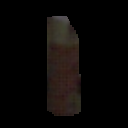

In [173]:
seg

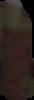

In [174]:
crop_seg

In [54]:
model.save("model.h5")